[Оригинальный файл на Kaggle](https://www.kaggle.com/code/sharthz23/metrics-validation-strategies-and-baselines)

# Расчёт метрик

In [30]:
import os
from collections import defaultdict

from more_itertools import pairwise
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose, initialize

In [31]:
sns.set_style("darkgrid")

In [32]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import precision_at_k, join_true_pred_and_preprocess, recall_at_k, mean_reciprocal_rank, mean_average_prec, compute_metrics
from recs_utils.load_data import MTSDataset, sample_true_rec_data
from recs_utils.simple_rec import PopularRecommender, PopularRecommenderPerAge, BaseRecommender
from recs_utils.split import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
with initialize(os.path.join("configs", "data"), version_base="1.3"):
    data_config = compose("mts_lib.yaml")

In [34]:
df = pl.read_parquet(data_config.dump_files.interactions_path)
df_users = pl.read_parquet(data_config.dump_files.users_path)
df_items = pl.read_parquet(data_config.dump_files.items_path)

In [35]:
df.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
66991,198453,89,NaN,2018-01-01
46791,83486,23,5.0,2018-01-01
79313,188770,88,5.0,2018-01-01


In [36]:
df.select("rating").unique()

rating
f32
NaN
5.0
1.0
2.0
3.0
4.0


In [37]:
sample_true, sample_rec = sample_true_rec_data()

In [38]:
joined_data = join_true_pred_and_preprocess(sample_true, sample_rec)

In [39]:
joined_data

user_id,item_id,rank,item_count_per_user
str,str,f64,u32
"""Аня""","""Мастер и Марга…",NaN,1
"""Боря""","""451° по Фаренг…",1.0,1
"""Вася""","""Зеленая миля""",3.0,2
"""Вася""","""Рита Хейуорт и…",NaN,2


In [40]:
joined_data = join_true_pred_and_preprocess(sample_true, sample_rec)

In [41]:
metric_value, joined_data = precision_at_k(joined_data, k=2)

In [42]:
metric_value

0.16666666666666666

In [43]:
joined_data

user_id,item_id,rank,item_count_per_user,hit@2,hit@2/2
str,str,f64,u32,bool,f64
"""Аня""","""Мастер и Марга…",NaN,1,false,0.0
"""Боря""","""451° по Фаренг…",1.0,1,true,0.5
"""Вася""","""Зеленая миля""",3.0,2,false,0.0
"""Вася""","""Рита Хейуорт и…",NaN,2,false,0.0


In [44]:
metric_value, joined_data = recall_at_k(joined_data, k=1)

In [45]:
metric_value

0.3333333333333333

In [46]:
joined_data

user_id,item_id,rank,item_count_per_user,hit@2,hit@2/2,hit@1
str,str,f64,u32,bool,f64,bool
"""Аня""","""Мастер и Марга…",NaN,1,false,0.0,false
"""Боря""","""451° по Фаренг…",1.0,1,true,0.5,true
"""Вася""","""Зеленая миля""",3.0,2,false,0.0,false
"""Вася""","""Рита Хейуорт и…",NaN,2,false,0.0,false


In [47]:
mean_reciprocal_rank(joined_data)

0.4444444444444444

In [48]:
mean_average_prec(joined_data)

0.3888888888888889

In [49]:
test_dates = df.select(pl.col("start_date").unique())[-7:].to_series().to_list()
test_dates = list(pairwise(test_dates))

In [50]:
test_dates

[(datetime.date(2019, 12, 25), datetime.date(2019, 12, 26)),
 (datetime.date(2019, 12, 26), datetime.date(2019, 12, 27)),
 (datetime.date(2019, 12, 27), datetime.date(2019, 12, 28)),
 (datetime.date(2019, 12, 28), datetime.date(2019, 12, 29)),
 (datetime.date(2019, 12, 29), datetime.date(2019, 12, 30)),
 (datetime.date(2019, 12, 30), datetime.date(2019, 12, 31))]

In [51]:
num_recs = 10

In [52]:
def validate(interactions: pl.DataFrame, user_features: pl.DataFrame, test_dates, model_cls, num_recs: int):
    metrics_per_fold = []

    for i, split_pair in enumerate(test_dates):
        train, test = train_test_split(interactions, split_pair)
        baseline: BaseRecommender = model_cls()
        baseline.fit(train, user_features)
        predicted_recs = baseline.recommend(test, user_features=user_features, num_recs_per_user=num_recs)

        assert predicted_recs.select(pl.col("user_id").n_unique())[0, 0] == test.select(pl.col("user_id").n_unique())[0, 0]

        metrics = compute_metrics(test, predicted_recs, num_recs)
        metrics = metrics.with_columns(pl.lit(i).alias("fold"), pl.lit(baseline.model_name).alias("model_name"))
        metrics_per_fold.append(metrics)

    return pl.concat(metrics_per_fold)

In [53]:
pop_metrics = validate(df, df_users, test_dates, PopularRecommender, num_recs=num_recs)

<Axes: xlabel='fold', ylabel='value'>

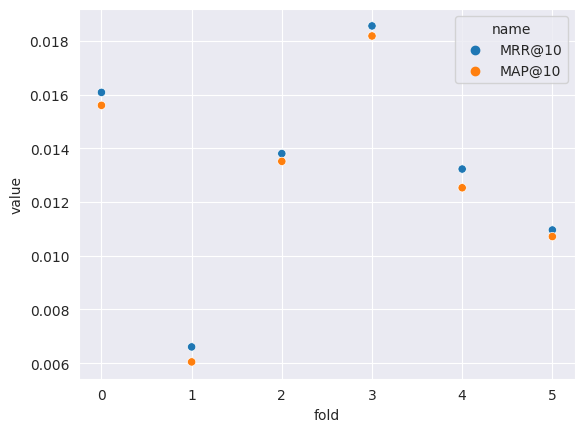

In [54]:
sns.scatterplot(data=pop_metrics.filter(pl.col("name").str.contains(r"(MAP@.+|MRR@.+)")), x="fold", y="value", hue="name")

In [55]:
pop_per_age_metrics = validate(df, df_users, test_dates, PopularRecommenderPerAge, num_recs=num_recs)

<Axes: xlabel='fold', ylabel='value'>

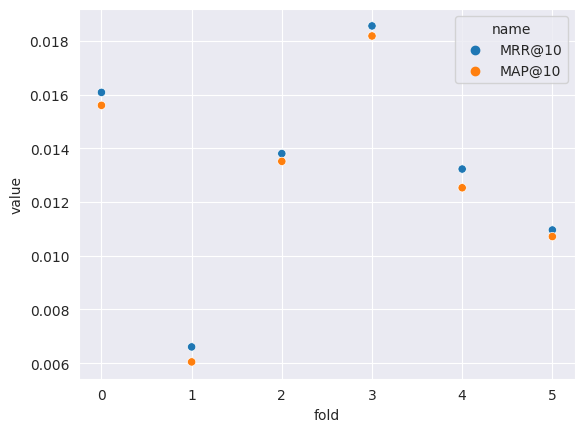

In [56]:
sns.scatterplot(data=pop_metrics.filter(pl.col("name").str.contains(r"(MAP@.+|MRR@.+)")), x="fold", y="value", hue="name")

In [57]:
all_metrics = pl.concat([pop_metrics, pop_per_age_metrics])

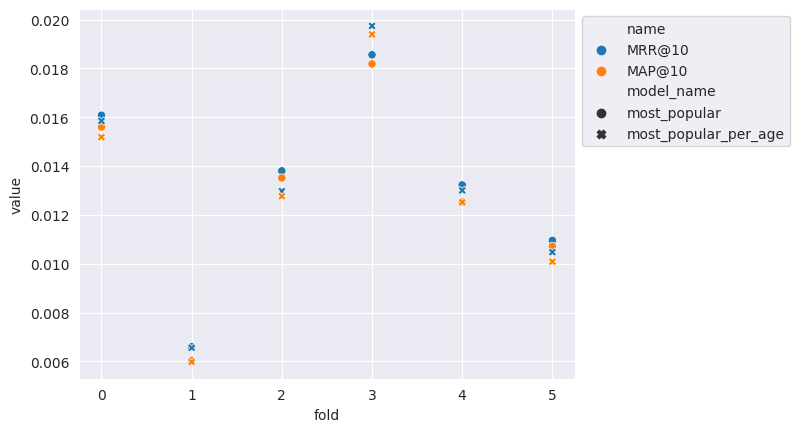

In [58]:
plot = sns.scatterplot(
    data=all_metrics.filter(pl.col("name").str.contains(r"(MAP@.+|MRR@.+)")), 
    x="fold", y="value", hue="name", style="model_name")
sns.move_legend(plot, loc="upper left", bbox_to_anchor=(1, 1))